In [1]:
# # Installing Packages
# options(repos = c(CRAN="https://cloud.r-project.org"))
# install.packages(c('fpp'))

In [158]:
library(dynlm)
library(car)
library(carData)
library(zoo)
library(xts)
library(tsbox)
library(tseries)
library(forecast)
library(vars)
library(fpp)
# Collect testing data everyday and number of cases in some cities day wise

In [163]:
# Making an xts object for the data
india <- as.data.frame(read.csv("../../Data/India_Time_Series.csv", sep = ",", colClasses=c("character","numeric", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric")))
india$Date <- as.Date(india$Date , format = "%d-%b")
india.xts <- xts(india, order.by=india$Date)
india.xts <- india.xts[, colnames(india.xts) != "Date"]                       
tail(india.xts)

           Daily.Confirmed Total.Confirmed Daily.Recovered Total.Recovered
2020-04-24 "1408"          "24447"         "484"           "5496"         
2020-04-25 "1835"          "26282"         "442"           "5938"         
2020-04-26 "1607"          "27890"         "585"           "6523"         
2020-04-27 "1568"          "29458"         "587"           "7110"         
2020-04-28 "1902"          "31360"         "637"           "7747"         
2020-04-29 "1702"          "33062"         "690"           "8437"         
           Daily.Deceased Total.Deceased Lockdown
2020-04-24 "59"           " 780"         "1"     
2020-04-25 "44"           " 824"         "1"     
2020-04-26 "56"           " 881"         "1"     
2020-04-27 "58"           " 939"         "1"     
2020-04-28 "69"           "1008"         "1"     
2020-04-29 "71"           "1079"         "1"     

In [164]:
# Taking the testing data (missing data points(3) are forecasted using Excel's built-in forecast)
testing <- as.data.frame(read.csv("../../Data/ICMRTestingDetails.csv", sep = ","))
testing <- testing[c("ï..Date", "DailySamples")]
colnames(testing) <- c("Date", "DailySamples")
tail(testing)
testing$Date <- as.Date(testing$Date , format = "%d-%m-%Y")
testing.xts <- xts(testing, order.by=testing$Date)
testing.xts <- testing.xts[, colnames(testing.xts) != "Date"] 
tail(testing)

,Date,DailySamples
42,23-04-2020,41247
43,24-04-2020,38168
44,25-04-2020,45352
45,26-04-2020,40510
46,27-04-2020,50914
47,28-04-2020,54031


,Date,DailySamples
42,2020-04-23,41247
43,2020-04-24,38168
44,2020-04-25,45352
45,2020-04-26,40510
46,2020-04-27,50914
47,2020-04-28,54031


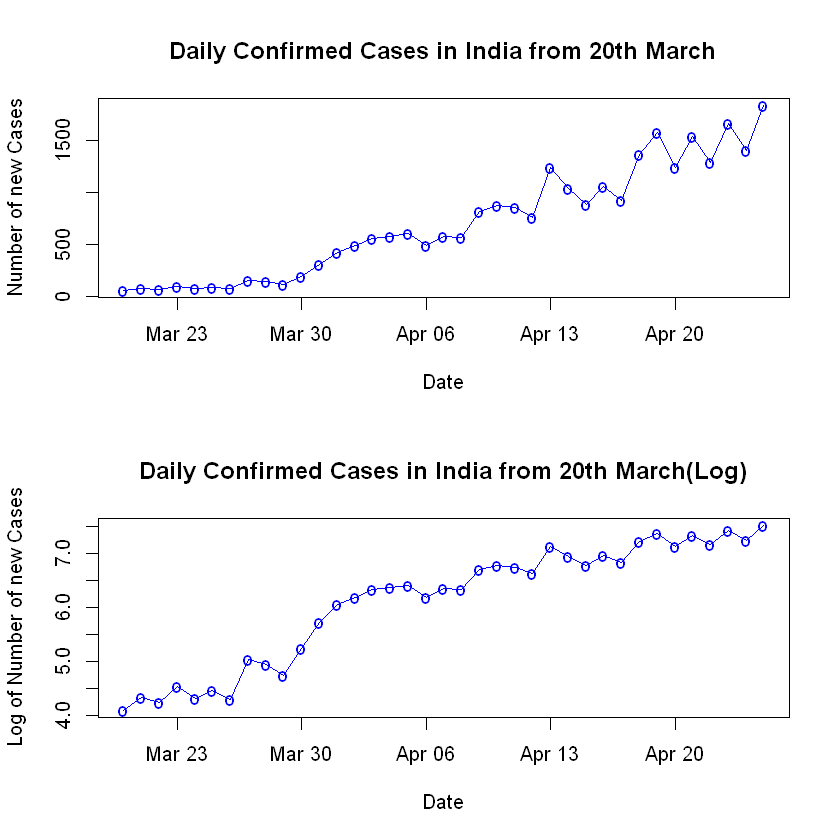

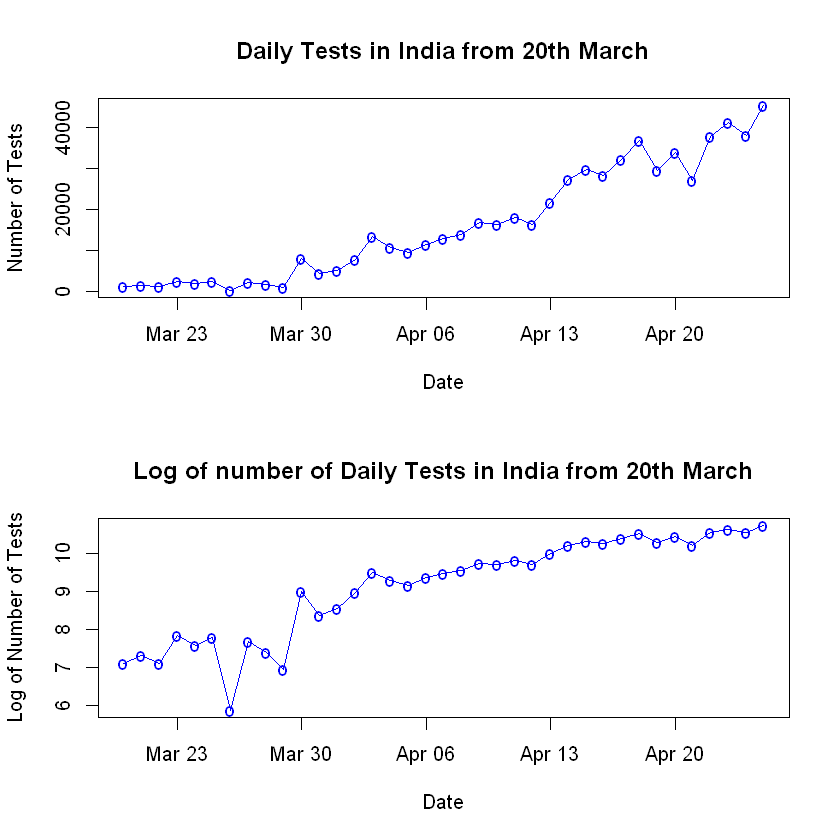

In [374]:
# Plotting Daily Data
# Keep start date after 18th March
startDate <- as.Date("20-Mar" , format = "%d-%b")
endDate <- as.Date("25-Apr" , format = "%d-%b")
newIndia.xts <- subset(india.xts, index(india.xts)>=startDate)
newIndia.xts <- subset(newIndia.xts, index(newIndia.xts)<=endDate)
newTesting.xts <- subset(testing.xts, index(testing.xts)>=startDate)
newTesting.xts <- subset(newTesting.xts, index(newTesting.xts)<=endDate)

par(mfrow = c(2,1)) # set up the graphics
# plot(index(india.xts), india.xts$Daily.Confirmed, type="o", col="blue", pch="o", lty=1, main="Daily Confirmed Cases in India", ylab="Number of new Cases", xlab="Date")
plot(index(newIndia.xts), newIndia.xts$Daily.Confirmed, type="o", col="blue", pch="o", lty=1, main="Daily Confirmed Cases in India from 20th March", ylab="Number of new Cases", xlab="Date")
plot(index(newIndia.xts), log(as.numeric(newIndia.xts$Daily.Confirmed)), type="o", col="blue", pch="o", lty=1, main="Daily Confirmed Cases in India from 20th March(Log)", ylab="Log of Number of new Cases", xlab="Date")

par(mfrow =  c(2,1))
plot(index(newTesting.xts), newTesting.xts$DailySamples, type="o", col="blue", pch="o", lty=1, main="Daily Tests in India from 20th March", ylab="Number of Tests", xlab="Date")
plot(index(newTesting.xts), log(as.numeric(newTesting.xts$DailySamples)), type="o", col="blue", pch="o", lty=1, main="Log of number of Daily Tests in India from 20th March", ylab="Log of Number of Tests", xlab="Date")


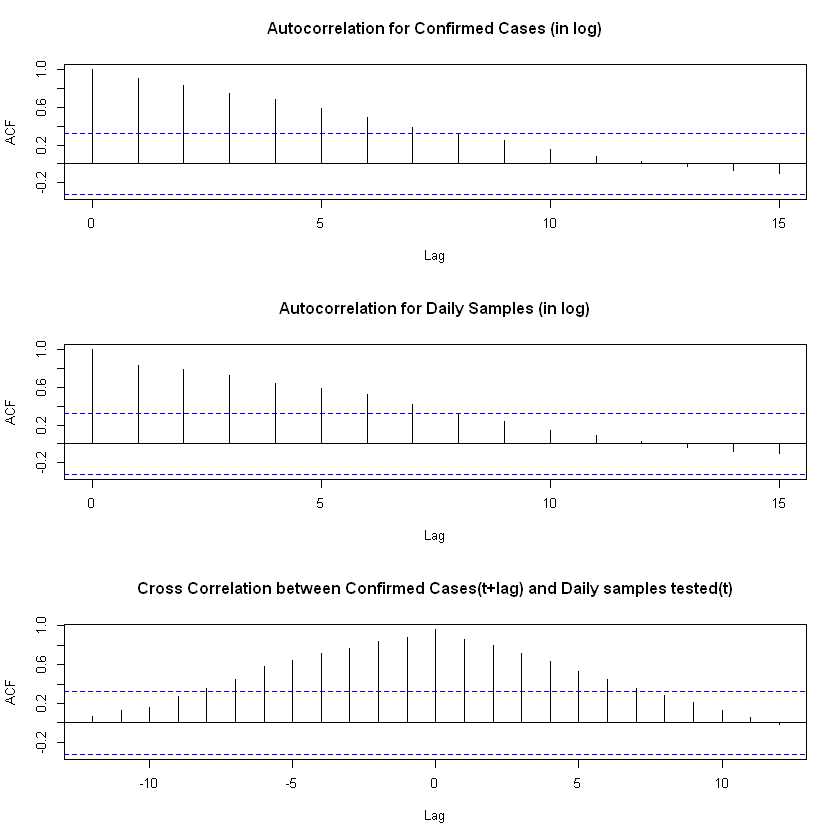

In [375]:
par(mfrow = c(3,1)) # set up the graphics
acf(log(as.numeric(newIndia.xts$Daily.Confirmed)), main="Autocorrelation for Confirmed Cases (in log)")
# ccf(log(as.numeric(newIndia.xts$Daily.Confirmed)), as.numeric(newIndia.xts$Lockdown), main="Cross Correlation between Confirmed Cases(t+lag) and Lockdown(t)")
acf(log(as.numeric(newTesting.xts$DailySamples)), main="Autocorrelation for Daily Samples (in log)")
ccf(log(as.numeric(newIndia.xts$Daily.Confirmed)), log(as.numeric(newTesting.xts$DailySamples)), main="Cross Correlation between Confirmed Cases(t+lag) and Daily samples tested(t)")
# There is high correlation for both positive and negative lags, hence we should use VAR as they both affect each other

In [376]:
# Date objects
DayZero <- as.Date("25-Mar" , format = "%d-%b")
DayOne <- as.Date("26-Mar" , format = "%d-%b")
DayTwo <- as.Date("27-Mar" , format = "%d-%b")
DayThree <- as.Date("28-Mar" , format = "%d-%b")
DayFour <- as.Date("29-Mar" , format = "%d-%b")
DayFive <- as.Date("30-Mar" , format = "%d-%b")
DaySix <- as.Date("31-Mar" , format = "%d-%b")
DaySeven <- as.Date("1-Apr" , format = "%d-%b")
DayEight <- as.Date("2-Apr" , format = "%d-%b")
DayNine <- as.Date("3-Apr" , format = "%d-%b")
DayTen <- as.Date("4-Apr" , format = "%d-%b")
DayEleven <- as.Date("5-Apr", format = "%d-%b")

# Creating columns
l1 <- (newIndia.xts$Lockdown)
l2 <- (newIndia.xts$Lockdown)
l3 <- (newIndia.xts$Lockdown)
l4 <- (newIndia.xts$Lockdown)
l5 <- (newIndia.xts$Lockdown)
l6 <- (newIndia.xts$Lockdown)
l7 <- (newIndia.xts$Lockdown)
l8 <- (newIndia.xts$Lockdown)
l9 <- (newIndia.xts$Lockdown)
l10 <- (newIndia.xts$Lockdown)
l11 <- (newIndia.xts$Lockdown)

l1 <- replace(l1, index(l1)<DayOne, "0")
l2 <- replace(l2, index(l2)<DayTwo, "0")
l3 <- replace(l3, index(l3)<DayThree, "0")
l4 <- replace(l4, index(l4)<DayFour, "0")
l5 <- replace(l5, index(l5)<DayFive, "0")
l6 <- replace(l6, index(l6)<DaySix, "0")
l7 <- replace(l7, index(l7)<DaySeven, "0")
l8 <- replace(l8, index(l8)<DayEight, "0")
l9 <- replace(l9, index(l9)<DayNine, "0")
l10 <- replace(l10, index(l10)<DayTen, "0")
l11 <- replace(l11, index(l11)<DayEleven, "0")

# Adding columns to newIndia.xts
newIndia.xts$Lockdown_1 <- l1
newIndia.xts$Lockdown_2 <- l2
newIndia.xts$Lockdown_3 <- l3
newIndia.xts$Lockdown_4 <- l4
newIndia.xts$Lockdown_5 <- l5
newIndia.xts$Lockdown_6 <- l6
newIndia.xts$Lockdown_7 <- l7
newIndia.xts$Lockdown_8 <- l8
newIndia.xts$Lockdown_9 <- l9
newIndia.xts$Lockdown_10 <- l10
newIndia.xts$Lockdown_11 <- l11

# Making the Data
# xreg.data <- data.frame(coredata(newIndia.xts$Lockdown), coredata(newIndia.xts$Lockdown_1), coredata(newIndia.xts$Lockdown_2), 
#                         coredata(newIndia.xts$Lockdown_3), coredata(newIndia.xts$Lockdown_4), coredata(newIndia.xts$Lockdown_5),
#                         coredata(newIndia.xts$Lockdown_6), coredata(newIndia.xts$Lockdown_7), coredata(newIndia.xts$Lockdown_8)
#                        , coredata(newIndia.xts$Lockdown_9), coredata(newIndia.xts$Lockdown_10))

# Making time squared trend to be fit
# Adding plus 1 kyunki baadme vo subtract ho jaayega
timeTrend_2 <- (1:length(index(newIndia.xts))) ^2 + 1
timeTrend <- (1:length(index(newIndia.xts))) + 1

xreg.data <- data.frame(coredata(newIndia.xts$Lockdown), timeTrend, timeTrend_2)

xreg.data.matrix <- data.matrix(xreg.data)-1
tail(xreg.data.matrix) # First let us remove the effects of time trend and lockdown

,Lockdown,timeTrend,timeTrend_2
"[32,]",1,32,1024
"[33,]",1,33,1089
"[34,]",1,34,1156
"[35,]",1,35,1225
"[36,]",1,36,1296
"[37,]",1,37,1369


## Model 1

### Structural Break followed by VAR. First we de-trend the data and then on the residuals we do the VAR

In [377]:
# Getting time trend and lockdown effect
nrows <- length(xreg.data$timeTrend)
print(nrows)
# Making a data with 6 columns, we can change entries according to the date
# Format-> Lockdown|Lockdown_1|time_trend_1|squared_time_trend_1|time_trend_2|squared_time_trend_2
modXreg.data <- xreg.data
modXreg.data <- cbind(xreg.data,time_trend_2=xreg.data$timeTrend,
                            squared_time_trend_2=xreg.data$timeTrend_2)
colnames(modXreg.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1", 
                           "time_trend_2", "squared_time_trend_2")

# modXreg.data <- xreg.data
# # modXreg.data <- cbind(xreg.data,time_trend_2=xreg.data$timeTrend,squared_time_trend_2=xreg.data$timeTrend_2)
# colnames(modXreg.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1")


# ARIMA Initialisation
dataTimeSeries <- log(as.numeric(newIndia.xts$Daily.Confirmed))
aicLevel <- 1000
# etaDate = today
# regressors <- data.matrix(modXreg.data)-1
# finalModel <- lm(dataTimeSeries ~ regressors)

# StartDate = 15th March
# Today = 17th April

for (eta in (3:(nrows-2))){
    tempXreg.data <- modXreg.data
    for (tempEta_2 in (1:(eta-1))){
        tempXreg.data[tempEta_2,"time_trend_2"] <- 1
        tempXreg.data[tempEta_2,"squared_time_trend_2"] <- 1
    }
    for (tempEta_1 in (eta:nrows)){
        tempXreg.data[tempEta_1,"time_trend_1"] <- 1
        tempXreg.data[tempEta_1,"squared_time_trend_1"] <- 1
    }
    
    tempXreg.matrix <- data.matrix(tempXreg.data)-1
    regressors <- tempXreg.matrix
    tempFit <- lm(dataTimeSeries ~ regressors)
    if(extractAIC(tempFit)[2] < aicLevel){
        aicLevel <- extractAIC(tempFit)[2]
        etaDate <- as.Date(startDate + eta)
        finalModel <- tempFit
    }
}
print(etaDate)
summary(finalModel)
extractAIC(finalModel)[2]
# finalModel$residuals

[1] 37
[1] "2020-04-01"



Call:
lm(formula = dataTimeSeries ~ regressors)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30597 -0.11543  0.00431  0.10930  0.32265 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     4.3127579  0.1734247  24.868  < 2e-16 ***
regressorsLockdown              0.0732656  0.1757627   0.417  0.67967    
regressorstime_trend_1         -0.0410779  0.0698358  -0.588  0.56065    
regressorssquared_time_trend_1  0.0101622  0.0055556   1.829  0.07701 .  
regressorstime_trend_2          0.1402750  0.0233558   6.006 1.21e-06 ***
regressorssquared_time_trend_2 -0.0016203  0.0004873  -3.325  0.00228 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1741 on 31 degrees of freedom
Multiple R-squared:  0.9789,	Adjusted R-squared:  0.9754 
F-statistic:   287 on 5 and 31 DF,  p-value: < 2.2e-16


[1] -123.9008

In [378]:
# residual <- (finalModel$residuals)
# # Plotting residuals
# par(mfrow = c(2,1)) # set up the graphics
# pacf((residual), main="Partial Autocorrelation for Residuals")
# acf((residual), main="Autocorrelation for Residuals")

In [379]:
# USE VAR model now on the residuals

dataTimeSeriesDF <- data.frame(finalModel$residuals, ((as.numeric(newTesting.xts$DailySamples))))
colnames(dataTimeSeriesDF) <- c("Residuals", "DailySamples")
mat <- data.matrix(dataTimeSeriesDF)
dataTimeSeries <- as.ts(mat)

fit <- VAR(dataTimeSeries, p=1, type="const")
summary(fit)


VAR Estimation Results:
Endogenous variables: Residuals, DailySamples 
Deterministic variables: const 
Sample size: 36 
Log Likelihood: -331.064 
Roots of the characteristic polynomial:
1.009 0.1475
Call:
VAR(y = dataTimeSeries, p = 1, type = "const")


Estimation results for equation Residuals: 
Residuals = Residuals.l1 + DailySamples.l1 + const 

                  Estimate Std. Error t value Pr(>|t|)
Residuals.l1    -1.451e-01  1.712e-01  -0.848    0.403
DailySamples.l1 -6.759e-07  2.112e-06  -0.320    0.751
const            1.520e-02  4.293e-02   0.354    0.726


Residual standard error: 0.1635 on 33 degrees of freedom
Multiple R-Squared: 0.02358,	Adjusted R-squared: -0.03559 
F-statistic: 0.3985 on 2 and 33 DF,  p-value: 0.6745 


Estimation results for equation DailySamples: 
DailySamples = Residuals.l1 + DailySamples.l1 + const 

                  Estimate Std. Error t value Pr(>|t|)    
Residuals.l1    -4.049e+03  4.039e+03  -1.003    0.323    
DailySamples.l1  1.007e+00  4.984

In [380]:
# Estimation with the model with structural breaks, for next four days
# Estimate residuals first with VAR
residualPredict <- predict(fit, n.ahead=4)
residualsForLM <- residualPredict$fcst$Residuals[,1]
residualsForLM

# Add these residuals to the prediction for lm model
# Setting the lockdown variable for future
lastDate <- index(newIndia.xts)[nrows]
startDate <- index(newIndia.xts)[1]

# today = as.Date("17-Apr", format="%d-%b")
lock <- sample(1:1, 4, replace = TRUE)
time_Before <- c(0,0,0,0)
time <- (((as.numeric(lastDate-startDate))+2):((as.numeric(lastDate-startDate))+5))
time_2 <- time * time

regressor.data <- data.frame(lock,time_Before,time_Before,time,time_2)
# regressor.data <- data.frame(lock,time,time_2)

colnames(regressor.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1", "time_trend_2", "squared_time_trend_2")
regressor.matrix <- data.matrix(regressor.data)

# Forecast
fore <- forecast(finalModel, h=4,  newdata=regressor.data)
summary(fore)
# plot(fore)
(fore$mean)
fin <- fore$mean + residualsForLM
exp(fin)
# plot(fin)

[1] -0.03820737 -0.01042954 -0.01551678 -0.01576619


Forecast method: Linear regression model

Model Information:

Call:
lm(formula = dataTimeSeries ~ regressors)

Coefficients:
                   (Intercept)              regressorsLockdown  
                       4.31276                         0.07327  
        regressorstime_trend_1  regressorssquared_time_trend_1  
                      -0.04108                         0.01016  
        regressorstime_trend_2  regressorssquared_time_trend_2  
                       0.14028                        -0.00162  


Error measures:
                      ME      RMSE       MAE         MPE     MAPE      MASE
Training set -7.2013e-17 0.1593748 0.1387286 -0.08697472 2.389211 0.1472822

Forecasts:
  Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1       7.376742 7.114200 7.639284 6.967827 7.785657
2       7.392253 7.120576 7.663930 6.969111 7.815395
3       7.404523 7.121997 7.687050 6.964483 7.844564
4       7.413553 7.118387 7.708719 6.953826 7.873280


1        2        3        4 
7.376742 7.392253 7.404523 7.413553

1        2        3        4 
1538.456 1606.516 1618.098 1632.368

## Model 2

### This model does not have any structural break, just a direct  VAR with lockdown and time trends

In [381]:
# VAR model without the structural break
nrows <- length(xreg.data$timeTrend)
print(nrows)
# Making a data with 6 columns, we can change entries according to the date
# Format-> Lockdown|Lockdown_1|time_trend_1|squared_time_trend_1|time_trend_2|squared_time_trend_2
modXreg.data <- xreg.data
# modXreg.data <- cbind(xreg.data,time_trend_2=xreg.data$timeTrend,squared_time_trend_2=xreg.data$timeTrend_2)
colnames(modXreg.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1")
# modXreg.data

# ARIMA Initialisation
dataTimeSeriesDF <- data.frame(log(as.numeric(newIndia.xts$Daily.Confirmed)), log(as.numeric(newTesting.xts$DailySamples)))
colnames(dataTimeSeriesDF) <- c("Daily.Confirmed", "DailySamples")
mat <- data.matrix(dataTimeSeriesDF)
dataTimeSeries <- as.ts(mat)

regressors <- data.matrix(modXreg.data)-1
noStructuralBreakModel <- VAR(dataTimeSeries, p=2)


summary(noStructuralBreakModel)

[1] 37



VAR Estimation Results:
Endogenous variables: Daily.Confirmed, DailySamples 
Deterministic variables: const 
Sample size: 35 
Log Likelihood: -11.535 
Roots of the characteristic polynomial:
0.9608 0.4054 0.1949 0.1949
Call:
VAR(y = dataTimeSeries, p = 2)


Estimation results for equation Daily.Confirmed: 
Daily.Confirmed = Daily.Confirmed.l1 + DailySamples.l1 + Daily.Confirmed.l2 + DailySamples.l2 + const 

                    Estimate Std. Error t value Pr(>|t|)   
Daily.Confirmed.l1  0.688929   0.214092   3.218  0.00309 **
DailySamples.l1    -0.070511   0.110969  -0.635  0.52998   
Daily.Confirmed.l2  0.343947   0.219835   1.565  0.12817   
DailySamples.l2    -0.003233   0.111078  -0.029  0.97698   
const               0.594623   0.429580   1.384  0.17651   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 0.2471 on 30 degrees of freedom
Multiple R-Squared: 0.9502,	Adjusted R-squared: 0.9436 
F-statistic: 143.2 on 4 and 30 DF,  p-value: 

In [382]:
# Forecasting model with everything in VAR (no structural break)
lastDate <- index(newIndia.xts)[nrows]
startDate <- index(newIndia.xts)[1]

# today = as.Date("17-Apr", format="%d-%b")
lock <- sample(1:1, 4, replace = TRUE)
time_Before <- c(0,0,0,0)
time <- (((as.numeric(lastDate-startDate))+2):((as.numeric(lastDate-startDate))+5))
time_2 <- time * time

regressor.data <- data.frame(lock,time,time_2)
colnames(regressor.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1")
regressor.matrix <- data.matrix(regressor.data)
# pred <- predict(noStructuralBreakModel, n.ahead=4, dumvar=regressor.matrix)
pred <- predict(noStructuralBreakModel, n.ahead=4)
logPred <- pred$fcst$Daily.Confirmed[,1]
predictions <- exp(logPred)
predictions
logPred
pred3 <- logPred
next3 <- logPred[1]
next3

[1] 1763.825 1894.411 1933.871 2011.603

[1] 7.475240 7.546663 7.567279 7.606687

[1] 7.47524

In [383]:
# dataTimeSeries

In [384]:
prediction3 <- fitted(noStructuralBreakModel)[,1]
prediction3 <- append(c(4.094345,4.330733), prediction3)

## Model 3

### No VAR, original model

In [385]:
# Making two beta waala model using auto-ARIMA and new datasets
nrows <- length(xreg.data$timeTrend)
print(nrows)
# Making a data with 6 columns, we can change entries according to the date
# Format-> Lockdown|Lockdown_1|time_trend_1|squared_time_trend_1|time_trend_2|squared_time_trend_2
modXreg.data <- xreg.data
modXreg.data <- cbind(modXreg.data,time_trend_2=xreg.data$timeTrend,squared_time_trend_2=xreg.data$timeTrend_2)
colnames(modXreg.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1", "time_trend_2", "squared_time_trend_2")
# modXreg.data


lockdown <- as.numeric(xreg.data$Lockdown)
lockdown <- lockdown-1
class(lockdown)
lockdown
# ARIMA Initialisation
dataTimeSeries <- log(as.numeric(newIndia.xts$Daily.Confirmed))
aicLevel <- 1000
# etaDate = today
# regressors <- data.matrix(modXreg.data)-1
finalModel <- auto.arima(dataTimeSeries, xreg=lockdown, method="ML")

# StartDate = 15th March
# Today = 17th April

# for (eta in (3:(nrows-2))){
#     tempXreg.data <- modXreg.data
#     for (tempEta_2 in (1:(eta-1))){
#         tempXreg.data[tempEta_2,"time_trend_2"] <- 1
#         tempXreg.data[tempEta_2,"squared_time_trend_2"] <- 1
#     }
#     for (tempEta_1 in (eta:nrows)){
#         tempXreg.data[tempEta_1,"time_trend_1"] <- 1
#         tempXreg.data[tempEta_1,"squared_time_trend_1"] <- 1
#     }
    
#     tempXreg.matrix <- data.matrix(tempXreg.data)-1
#     regressors <- tempXreg.matrix
#     tempFit <- auto.arima(dataTimeSeries, xreg=regressors, method="ML")
#     if(tempFit$aicc < aicLevel){
#         aicLevel <- tempFit$aicc
#         etaDate <- as.Date(startDate + eta)
#         finalModel <- tempFit
#     }
# }
# print(etaDate)
summary(finalModel)
finalModel

[1] 37


[1] "numeric"

[1] 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Series: dataTimeSeries 
Regression with ARIMA(1,1,0) errors 

Coefficients:
          ar1   drift     xreg
      -0.3579  0.0965  -0.1354
s.e.   0.1611  0.0295   0.2347

sigma^2 estimated as 0.05929:  log likelihood=1.27
AIC=5.45   AICc=6.75   BIC=11.79

Training set error measures:
                      ME      RMSE       MAE       MPE     MAPE      MASE
Training set 0.001210592 0.2299511 0.1847271 0.0480709 3.162679 0.8459725
                    ACF1
Training set -0.01215353


Series: dataTimeSeries 
Regression with ARIMA(1,1,0) errors 

Coefficients:
          ar1   drift     xreg
      -0.3579  0.0965  -0.1354
s.e.   0.1611  0.0295   0.2347

sigma^2 estimated as 0.05929:  log likelihood=1.27
AIC=5.45   AICc=6.75   BIC=11.79

In [386]:
# Forecasting this model
# Forecasting the above model
# Setting the lockdown variable for future
lastDate <- index(newIndia.xts)[nrows]
startDate <- index(newIndia.xts)[1]
# today = as.Date("17-Apr", format="%d-%b")
lock <- sample(1:1, 4, replace = TRUE)
time_Before <- c(0,0,0,0)
time <- ((as.numeric(lastDate-startDate)+2):(as.numeric(lastDate-startDate)+5))
time_2 <- time * time

# regressor.data <- data.frame(lock,time_Before,time_Before,time,time_2)
regressor.data <- data.frame(lock)

colnames(regressor.data)<- c("Lockdown")
# colnames(regressor.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1", "time_trend_2", "squared_time_trend_2")
regressor.matrix <- data.matrix(regressor.data)
regressor.matrix
# Forecast
fore <- forecast(finalModel, h=4,  xreg=c(1,1,1,1))
summary(fore)
# plot(fore)
(fore$mean)
exp((fore$mean))
pred4 <- fore$mean
next4 <- pred4[1]
pred4
next4

Lockdown
1
1
1
1



Forecast method: Regression with ARIMA(1,1,0) errors

Model Information:
Series: dataTimeSeries 
Regression with ARIMA(1,1,0) errors 

Coefficients:
          ar1   drift     xreg
      -0.3579  0.0965  -0.1354
s.e.   0.1611  0.0295   0.2347

sigma^2 estimated as 0.05929:  log likelihood=1.27
AIC=5.45   AICc=6.75   BIC=11.79

Error measures:
                      ME      RMSE       MAE       MPE     MAPE      MASE
Training set 0.001210592 0.2299511 0.1847271 0.0480709 3.162679 0.8459725
                    ACF1
Training set -0.01215353

Forecasts:
   Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
38       7.551064 7.239020 7.863107 7.073834 8.028293
39       7.669143 7.298307 8.039979 7.101999 8.236287
40       7.757942 7.316037 8.199847 7.082106 8.433778
41       7.857220 7.360862 8.353577 7.098107 8.616333


Time Series:
Start = 38 
End = 41 
Frequency = 1 
[1] 7.551064 7.669143 7.757942 7.857220

Time Series:
Start = 38 
End = 41 
Frequency = 1 
[1] 1902.766 2141.245 2340.084 2584.326

Time Series:
Start = 38 
End = 41 
Frequency = 1 
[1] 7.551064 7.669143 7.757942 7.857220

[1] 7.551064

In [387]:
# Finding the fitted values for this model
fit4 <- finalModel
fit4$x
days <- nrows
prediction4 <- fit4$x - fit4$residuals
prediction4

Time Series:
Start = 1 
End = 37 
Frequency = 1 
 [1] 4.094345 4.330733 4.234107 4.543295 4.304065 4.454347 4.290459 5.030438
 [9] 4.948760 4.744932 5.247024 5.723585 6.049733 6.186209 6.327937 6.361302
[17] 6.405228 6.192362 6.350886 6.336826 6.700731 6.769642 6.749931 6.630683
[25] 7.125283 6.942157 6.782192 6.966967 6.826545 7.222566 7.365180 7.122060
[33] 7.337588 7.163947 7.418781 7.249926 7.514800

Time Series:
Start = 1 
End = 37 
Frequency = 1 
 [1] 4.090347 4.200123 4.377192 4.399745 4.563700 4.385377 4.483178 4.480169
 [9] 4.896671 5.109048 4.948936 5.198392 5.684090 6.064069 6.268424 6.408272
[17] 6.480419 6.520566 6.399600 6.425211 6.472915 6.701554 6.876037 6.888043
[25] 6.804417 7.079333 7.138751 6.970498 7.031897 7.007857 7.211895 7.445199
[33] 7.340125 7.391512 7.357147 7.458638 7.441413

## Model 4

### No structural break, just de-trend the data to find out that the residuals are white noise (do the test)

In [388]:
# Making two beta waala model using auto-ARIMA and new datasets
nrows <- length(xreg.data$timeTrend)
print(nrows)
# Making a data with 6 columns, we can change entries according to the date
# Format-> Lockdown|Lockdown_1|time_trend_1|squared_time_trend_1|time_trend_2|squared_time_trend_2
modXreg.data <- xreg.data
colnames(modXreg.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1")

# ARIMA Initialisation
dataTimeSeries <- log(as.numeric(newIndia.xts$Daily.Confirmed))
aicLevel <- 1000
# etaDate = today
regressors <- data.matrix(modXreg.data)-1
finalModel <- lm(dataTimeSeries ~ regressors)

summary(finalModel)

[1] 37



Call:
lm(formula = dataTimeSeries ~ regressors)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47848 -0.12383 -0.03517  0.19099  0.37855 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     3.6651970  0.1216161  30.137  < 2e-16 ***
regressorsLockdown             -0.3637240  0.1929673  -1.885   0.0683 .  
regressorstime_trend_1          0.2235257  0.0228068   9.801 2.67e-11 ***
regressorssquared_time_trend_1 -0.0031332  0.0005218  -6.004 9.53e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2329 on 33 degrees of freedom
Multiple R-squared:  0.9597,	Adjusted R-squared:  0.9561 
F-statistic: 262.1 on 3 and 33 DF,  p-value: < 2.2e-16


In [389]:
# Forecasting the above model
# Setting the lockdown variable for future
lastDate <- index(newIndia.xts)[nrows]
# today = as.Date("17-Apr", format="%d-%b")
lock <- sample(1:1, 4, replace = TRUE)
time_Before <- c(0,0,0,0)
time <- ((as.numeric(lastDate-startDate)+2):(as.numeric(lastDate-startDate)+5))
time_2 <- time * time

# regressor.data <- data.frame(lock,time_Before,time_Before,time,time_2)
regressor.data <- data.frame(lock,time,time_2)

colnames(regressor.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1")
regressor.matrix <- data.matrix(regressor.data)

# Forecast
fore <- forecast(finalModel, h=4,  newdata=regressor.data)
summary(fore)
# plot(fore)
# (fore$mean)
exp((fore$mean))


Forecast method: Linear regression model

Model Information:

Call:
lm(formula = dataTimeSeries ~ regressors)

Coefficients:
                   (Intercept)              regressorsLockdown  
                      3.665197                       -0.363724  
        regressorstime_trend_1  regressorssquared_time_trend_1  
                      0.223526                       -0.003133  


Error measures:
                        ME      RMSE       MAE        MPE     MAPE      MASE
Training set -1.199875e-17 0.2199314 0.1830125 -0.1636253 3.218263 0.1942965

Forecasts:
  Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1       7.271097 6.922465 7.619728 6.728712 7.813481
2       7.253365 6.893845 7.612885 6.694041 7.812690
3       7.229368 6.857078 7.601658 6.650177 7.808559
4       7.199104 6.812087 7.586120 6.597002 7.801205


1        2        3        4 
1438.127 1412.852 1379.350 1338.231

## Model 5

### Detrend both daily cases and daily samples waala data, with structural break and then apply VAR

In [390]:
# Getting time trend and lockdown effect
nrows <- length(xreg.data$timeTrend)
print(nrows)
# Making a data with 6 columns, we can change entries according to the date
# Format-> Lockdown|Lockdown_1|time_trend_1|squared_time_trend_1|time_trend_2|squared_time_trend_2
modXreg.data1 <- xreg.data
modXreg.data1 <- cbind(xreg.data,time_trend_2=xreg.data$timeTrend,
                            squared_time_trend_2=xreg.data$timeTrend_2)
colnames(modXreg.data1)<- c("Lockdown", "time_trend_1", "squared_time_trend_1", 
                           "time_trend_2", "squared_time_trend_2")
modXreg.data2 <- xreg.data[,-3]
modXreg.data2 <- cbind(modXreg.data2,time_trend_2=xreg.data$timeTrend)
colnames(modXreg.data2)<- c("Lockdown", "time_trend_1", 
                           "time_trend_2")


# ARIMA Initialisation
dataTimeSeries1 <- log(as.numeric(newIndia.xts$Daily.Confirmed))
dataTimeSeries2 <- log(as.numeric(newTesting.xts$DailySamples))
# dataTimeSeries1
aicLevel1 <- 1000
aicLevel2 <- 1000

for (eta in (3:(nrows-2))){
    tempXreg.data1 <- modXreg.data1
    tempXreg.data2 <- modXreg.data2
    for (tempEta_2 in (1:(eta-1))){
        tempXreg.data1[tempEta_2,"time_trend_2"] <- 1
        tempXreg.data1[tempEta_2,"squared_time_trend_2"] <- 1
        tempXreg.data2[tempEta_2,"time_trend_2"] <- 1
    }
    for (tempEta_1 in (eta:nrows)){
        tempXreg.data1[tempEta_1,"time_trend_1"] <- 1
        tempXreg.data1[tempEta_1,"squared_time_trend_1"] <- 1
        tempXreg.data2[tempEta_1,"time_trend_1"] <- 1
    }
    
    tempXreg.matrix1 <- data.matrix(tempXreg.data1)-1
    regressors1 <- tempXreg.matrix1
    tempFit1 <- lm(dataTimeSeries1 ~ regressors1)
    if(extractAIC(tempFit1)[2] < aicLevel1){
        aicLevel1 <- extractAIC(tempFit1)[2]
        etaDate1 <- as.Date(startDate + eta)
        finalModel1 <- tempFit1
    }
    tempXreg.matrix2 <- data.matrix(tempXreg.data2)-1
    regressors2 <- tempXreg.matrix2
    tempFit2 <- lm(dataTimeSeries2 ~ regressors2)
    if(extractAIC(tempFit2)[2] < aicLevel2){
        aicLevel2 <- extractAIC(tempFit2)[2]
        etaDate2 <- as.Date(startDate + eta)
        finalModel2 <- tempFit2
    }
}
print(etaDate1)
print(etaDate2) # For daily samples
summary(finalModel1)
summary(finalModel2)
extractAIC(finalModel1)[2]
extractAIC(finalModel2)[2]

[1] 37
[1] "2020-04-01"
[1] "2020-03-31"



Call:
lm(formula = dataTimeSeries1 ~ regressors1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30597 -0.11543  0.00431  0.10930  0.32265 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      4.3127579  0.1734247  24.868  < 2e-16 ***
regressors1Lockdown              0.0732656  0.1757627   0.417  0.67967    
regressors1time_trend_1         -0.0410779  0.0698358  -0.588  0.56065    
regressors1squared_time_trend_1  0.0101622  0.0055556   1.829  0.07701 .  
regressors1time_trend_2          0.1402750  0.0233558   6.006 1.21e-06 ***
regressors1squared_time_trend_2 -0.0016203  0.0004873  -3.325  0.00228 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1741 on 31 degrees of freedom
Multiple R-squared:  0.9789,	Adjusted R-squared:  0.9754 
F-statistic:   287 on 5 and 31 DF,  p-value: < 2.2e-16



Call:
lm(formula = dataTimeSeries2 ~ regressors2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.40916 -0.10739  0.06398  0.21100  0.53281 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              7.619858   0.187325  40.677  < 2e-16 ***
regressors2Lockdown      0.192586   0.220064   0.875   0.3878    
regressors2time_trend_1 -0.074281   0.031781  -2.337   0.0256 *  
regressors2time_trend_2  0.083174   0.008485   9.802 2.66e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3606 on 33 degrees of freedom
Multiple R-squared:  0.9302,	Adjusted R-squared:  0.9238 
F-statistic: 146.6 on 3 and 33 DF,  p-value: < 2.2e-16


[1] -123.9008

[1] -71.72017

In [391]:
# par(mfrow = c(3,1)) # set up the graphics
# acf((as.numeric(finalModel1$residuals)), main="Autocorrelation for Residuals of Confirmed Cases (in log)")
# # ccf(log(as.numeric(newIndia.xts$Daily.Confirmed)), as.numeric(newIndia.xts$Lockdown), main="Cross Correlation between Confirmed Cases(t+lag) and Lockdown(t)")
# acf((as.numeric(finalModel2$residuals)), main="Autocorrelation for Residuals of Daily Samples (in log)")
# ccf((as.numeric(finalModel1$residuals)), (as.numeric(finalModel2$residuals)), main="Cross Correlation between Residuals of Confirmed Cases(t+lag) and Residuals of Daily samples tested(t)")
# # There is high correlation for both positive and negative lags, hence we should use VAR as they both affect each other
# # plot(finalModel1$residuals)

In [392]:
# Apply VAR on these residuals
dataTimeSeriesDF <- data.frame(finalModel1$residuals, finalModel2$residuals)
colnames(dataTimeSeriesDF) <- c("ResidualsDailyCases", "ResidualsDailySamples")
mat <- data.matrix(dataTimeSeriesDF)
dataTimeSeries <- as.ts(mat)

fit <- VAR(dataTimeSeries, p=1, type="const")
summary(fit)


VAR Estimation Results:
Endogenous variables: ResidualsDailyCases, ResidualsDailySamples 
Deterministic variables: const 
Sample size: 36 
Log Likelihood: 10.404 
Roots of the characteristic polynomial:
0.1319 0.1319
Call:
VAR(y = dataTimeSeries, p = 1, type = "const")


Estimation results for equation ResidualsDailyCases: 
ResidualsDailyCases = ResidualsDailyCases.l1 + ResidualsDailySamples.l1 + const 

                         Estimate Std. Error t value Pr(>|t|)  
ResidualsDailyCases.l1    0.06428    0.17250   0.373   0.7118  
ResidualsDailySamples.l1 -0.21715    0.07992  -2.717   0.0104 *
const                     0.00650    0.02469   0.263   0.7940  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 0.148 on 33 degrees of freedom
Multiple R-Squared: 0.1996,	Adjusted R-squared: 0.1511 
F-statistic: 4.115 on 2 and 33 DF,  p-value: 0.02537 


Estimation results for equation ResidualsDailySamples: 
ResidualsDailySamples = ResidualsDailyCase

In [393]:
# Forecast using fit
# Estimation with the model with structural breaks, for next four days
# Estimate residuals first with VAR
residualPredict <- predict(fit, n.ahead=4)
residualsForLM <- residualPredict$fcst$ResidualsDailyCases[,1]
residualsForLM

# Add these residuals to the prediction for lm model
# Setting the lockdown variable for future
lastDate <- index(newIndia.xts)[nrows]
startDate <- index(newIndia.xts)[1]

# today = as.Date("17-Apr", format="%d-%b")
lock <- sample(1:1, 4, replace = TRUE)
time_Before <- c(0,0,0,0)
time <- (((as.numeric(lastDate-startDate))+2):((as.numeric(lastDate-startDate))+5))
time
time_2 <- time * time

regressor.data <- data.frame(lock,time_Before,time_Before,time,time_2)
# regressor.data <- data.frame(lock,time,time_2)

colnames(regressor.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1", "time_trend_2", "squared_time_trend_2")
regressor.matrix <- data.matrix(regressor.data)

# Forecast
fore <- forecast(finalModel1, h=4,  newdata=regressor.data)
summary(fore)
# plot(fore)
(fore$mean)
pred2 <- fore$mean
variance <- var(finalModel1$residuals)
variance <- variance/2
exp(fore$mean + residualsForLM)
fin <- fore$mean + residualsForLM + variance
exp(fin)
next2 <- fore$mean[1]
# plot(fin)

[1]  0.052990898 -0.003011757  0.003997472  0.004320096

[1] 38 39 40 41


Forecast method: Linear regression model

Model Information:

Call:
lm(formula = dataTimeSeries1 ~ regressors1)

Coefficients:
                    (Intercept)              regressors1Lockdown  
                        4.31276                          0.07327  
        regressors1time_trend_1  regressors1squared_time_trend_1  
                       -0.04108                          0.01016  
        regressors1time_trend_2  regressors1squared_time_trend_2  
                        0.14028                         -0.00162  


Error measures:
                     ME      RMSE       MAE         MPE     MAPE      MASE
Training set 7.2013e-17 0.1593748 0.1387286 -0.08697472 2.389211 0.1472822

Forecasts:
  Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1       7.376742 7.114200 7.639284 6.967827 7.785657
2       7.392253 7.120576 7.663930 6.969111 7.815395
3       7.404523 7.121997 7.687050 6.964483 7.844564
4       7.413553 7.118387 7.708719 6.953826 7.873280


1        2        3        4 
7.376742 7.392253 7.404523 7.413553

1        2        3        4 
1685.357 1618.478 1649.984 1665.487

1        2        3        4 
1707.500 1639.742 1671.662 1687.369

In [394]:
# fit$fitted.values
res <- fitted(fit)[,1]
# finalModel1$fitted.values
res <- append(c(0),res)
# res
prediction2 <- finalModel1$fitted.values + res
# prediction2

## Model 6

### Detrend both daily cases and daily samples waala data, without structural break and then apply VAR

In [395]:
# Making two beta waala model using auto-ARIMA and new datasets
nrows <- length(xreg.data$timeTrend)
print(nrows)
# Making a data with 6 columns, we can change entries according to the date
# Format-> Lockdown|Lockdown_1|time_trend_1|squared_time_trend_1|time_trend_2|squared_time_trend_2
modXreg.data1 <- xreg.data
colnames(modXreg.data1)<- c("Lockdown", "time_trend_1", "squared_time_trend_1")
modXreg.data2 <- xreg.data[,-3]

# # ARIMA Initialisation
dataTimeSeries1 <- log(as.numeric(newIndia.xts$Daily.Confirmed))
dataTimeSeries2 <- log(as.numeric(newTesting.xts$DailySamples))

regressors1 <- data.matrix(modXreg.data1)-1
regressors2 <- data.matrix(modXreg.data2)-1

finalModel1 <- lm(dataTimeSeries1 ~ regressors1)
finalModel2 <- lm(dataTimeSeries2 ~ regressors2)

summary(finalModel1)
summary(finalModel2)

[1] 37



Call:
lm(formula = dataTimeSeries1 ~ regressors1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47848 -0.12383 -0.03517  0.19099  0.37855 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      3.6651970  0.1216161  30.137  < 2e-16 ***
regressors1Lockdown             -0.3637240  0.1929673  -1.885   0.0683 .  
regressors1time_trend_1          0.2235257  0.0228068   9.801 2.67e-11 ***
regressors1squared_time_trend_1 -0.0031332  0.0005218  -6.004 9.53e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2329 on 33 degrees of freedom
Multiple R-squared:  0.9597,	Adjusted R-squared:  0.9561 
F-statistic: 262.1 on 3 and 33 DF,  p-value: < 2.2e-16



Call:
lm(formula = dataTimeSeries2 ~ regressors2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8809 -0.1880  0.1138  0.3034  0.8337 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           7.05778    0.23238  30.372  < 2e-16 ***
regressors2Lockdown  -0.08509    0.30762  -0.277    0.784    
regressors2timeTrend  0.11308    0.00985  11.480 3.03e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5154 on 34 degrees of freedom
Multiple R-squared:  0.853,	Adjusted R-squared:  0.8444 
F-statistic: 98.68 on 2 and 34 DF,  p-value: 6.952e-15


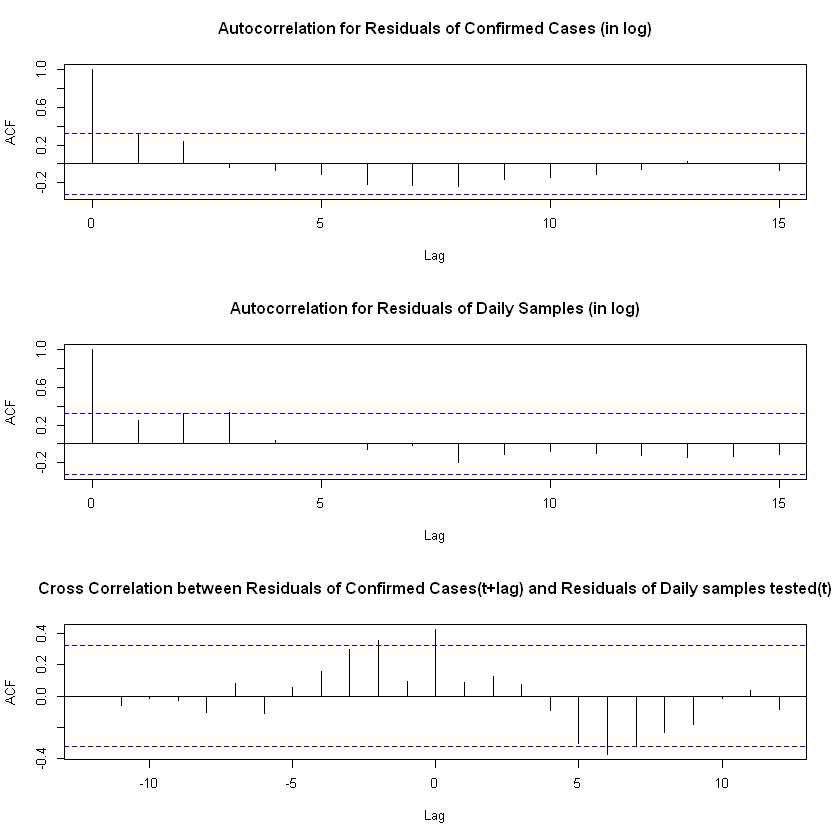

In [396]:
par(mfrow = c(3,1)) # set up the graphics
acf((as.numeric(finalModel1$residuals)), main="Autocorrelation for Residuals of Confirmed Cases (in log)")
# ccf(log(as.numeric(newIndia.xts$Daily.Confirmed)), as.numeric(newIndia.xts$Lockdown), main="Cross Correlation between Confirmed Cases(t+lag) and Lockdown(t)")
acf((as.numeric(finalModel2$residuals)), main="Autocorrelation for Residuals of Daily Samples (in log)")
ccf((as.numeric(finalModel1$residuals)), (as.numeric(finalModel2$residuals)), main="Cross Correlation between Residuals of Confirmed Cases(t+lag) and Residuals of Daily samples tested(t)")
# There is high correlation for both positive and negative lags, hence we should use VAR as they both affect each other
# plot(finalModel1$residuals)

In [397]:
# Apply VAR on these residuals
dataTimeSeriesDF <- data.frame(finalModel1$residuals, finalModel2$residuals)
colnames(dataTimeSeriesDF) <- c("ResidualsDailyCases", "ResidualsDailySamples")
mat <- data.matrix(dataTimeSeriesDF)
dataTimeSeries <- as.ts(mat)

fit <- VAR(dataTimeSeries, p=2, type="const")
summary(fit)


VAR Estimation Results:
Endogenous variables: ResidualsDailyCases, ResidualsDailySamples 
Deterministic variables: const 
Sample size: 35 
Log Likelihood: -12.217 
Roots of the characteristic polynomial:
0.6087 0.4469 0.3715 0.03189
Call:
VAR(y = dataTimeSeries, p = 2, type = "const")


Estimation results for equation ResidualsDailyCases: 
ResidualsDailyCases = ResidualsDailyCases.l1 + ResidualsDailySamples.l1 + ResidualsDailyCases.l2 + ResidualsDailySamples.l2 + const 

                          Estimate Std. Error t value Pr(>|t|)
ResidualsDailyCases.l1    0.289000   0.209140   1.382    0.177
ResidualsDailySamples.l1 -0.030497   0.088500  -0.345    0.733
ResidualsDailyCases.l2    0.125413   0.205410   0.611    0.546
ResidualsDailySamples.l2  0.027162   0.089173   0.305    0.763
const                    -0.008519   0.037757  -0.226    0.823


Residual standard error: 0.2222 on 30 degrees of freedom
Multiple R-Squared: 0.122,	Adjusted R-squared: 0.00488 
F-statistic: 1.042 on 4 and 30

In [398]:
# Forecast using fit
# Estimation with the model with structural breaks, for next four days
# Estimate residuals first with VAR
residualPredict <- predict(fit, n.ahead=4)
residualsForLM <- residualPredict$fcst$ResidualsDailyCases[,1]
residualsForLM

# Add these residuals to the prediction for lm model
# Setting the lockdown variable for future
lastDate <- index(newIndia.xts)[nrows]
startDate <- index(newIndia.xts)[1]

# today = as.Date("17-Apr", format="%d-%b")
lock <- sample(1:1, 4, replace = TRUE)
time_Before <- c(0,0,0,0)
time <- (((as.numeric(lastDate-startDate))+2):((as.numeric(lastDate-startDate))+5))
time_2 <- time * time

regressor.data <- data.frame(lock,time,time_2)
# regressor.data <- data.frame(lock,time,time_2)


colnames(regressor.data)<- c("Lockdown", "time_trend_1", "squared_time_trend_1")
regressor.matrix <- data.matrix(regressor.data)

# Forecast
fore <- forecast(finalModel1, newdata=regressor.data)
# fore
variance <- var(finalModel1$residuals)
variance <- variance/2
summary(fore)
# plot(fore)
(fore$mean)
pred1 <- fore$mean
fin <- fore$mean + residualsForLM + variance
exp(fore$mean + residualsForLM)
exp(fin)
next1 <- fore$mean[1]
next1
# # plot(fin)

[1]  0.0536885201  0.0338646641 -0.0005234117 -0.0037044363


Forecast method: Linear regression model

Model Information:

Call:
lm(formula = dataTimeSeries1 ~ regressors1)

Coefficients:
                    (Intercept)              regressors1Lockdown  
                       3.665197                        -0.363724  
        regressors1time_trend_1  regressors1squared_time_trend_1  
                       0.223526                        -0.003133  


Error measures:
                       ME      RMSE       MAE        MPE     MAPE      MASE
Training set 7.201373e-17 0.2199314 0.1830125 -0.1636253 3.218263 0.1942965

Forecasts:
  Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1       7.271097 6.922465 7.619728 6.728712 7.813481
2       7.253365 6.893845 7.612885 6.694041 7.812690
3       7.229368 6.857078 7.601658 6.650177 7.808559
4       7.199104 6.812087 7.586120 6.597002 7.801205


1        2        3        4 
7.271097 7.253365 7.229368 7.199104

1        2        3        4 
1517.448 1461.517 1378.628 1333.282

1        2        3        4 
1555.640 1498.301 1413.326 1366.839

1 
7.271097

In [370]:
# fit$fitted.values
res <- fitted(fit)[,1]
# finalModel1$fitted.values
res <- append(c(0,0),res)
# res
prediction1 <- finalModel1$fitted.values + res
# prediction1

## Model 55555

In [371]:
timeseries <- log(as.numeric(newIndia.xts$Daily.Confirmed))
model5 <- lm(timeseries~prediction1+prediction2+prediction3+prediction4)
summary(model5)


Call:
lm(formula = timeseries ~ prediction1 + prediction2 + prediction3 + 
    prediction4)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.237723 -0.114269  0.001517  0.107420  0.232270 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.1835     0.3040  -0.604    0.550    
prediction1   0.1148     0.2577   0.445    0.659    
prediction2   0.9303     0.1535   6.061 6.43e-07 ***
prediction3   0.3926     0.8055   0.487    0.629    
prediction4  -0.4087     0.7463  -0.548    0.587    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1485 on 35 degrees of freedom
Multiple R-squared:  0.9843,	Adjusted R-squared:  0.9826 
F-statistic: 550.1 on 4 and 35 DF,  p-value: < 2.2e-16


In [372]:
# Forecasting from this model, four day forecast
# firstPred <- c(7.27109679304154, 7.25336545198217, 7.22936769425272, 7.1991035198532)
# secondPred <- c(7.37674201741267, 7.39225293609956, 7.4045232290743, 7.4135528963369)
# thirdPred <- c(7.47524026189765, 7.54666330110434, 7.56727872054963, 7.6066872817164)
# fourthPred <- c(7.686426, 7.804505, 7.893304, 7.992581)
regressor.data <- data.frame(pred1, pred2, pred3, pred4)
colnames(regressor.data) <- c("prediction1", "prediction2", "prediction3", "prediction4")
fore <- forecast(model5, newdata=regressor.data)
summary(fore)
variance <- var(fore$residuals)
variance <- variance/2
preds <- fore$mean + variance
exp(preds)


Forecast method: Linear regression model

Model Information:

Call:
lm(formula = timeseries ~ prediction1 + prediction2 + prediction3 + 
    prediction4)

Coefficients:
(Intercept)  prediction1  prediction2  prediction3  prediction4  
    -0.1835       0.1148       0.9303       0.3926      -0.4087  


Error measures:
             ME      RMSE       MAE         MPE     MAPE      MASE
Training set  0 0.1389128 0.1170672 -0.06259618 1.920611 0.1248613

Forecasts:
  Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1       7.427225 7.219444 7.635007 7.104293 7.750158
2       7.414022 7.192276 7.635768 7.069386 7.758659
3       7.388895 7.138638 7.639152 6.999947 7.777844
4       7.363250 7.074641 7.651859 6.914695 7.811804


1        2        3        4 
1697.855 1675.586 1634.008 1592.636

In [373]:
regressor.data <- data.frame(next1, next2, next3, next4)
colnames(regressor.data) <- c("prediction1", "prediction2", "prediction3", "prediction4")
fore <- forecast(model5, newdata=regressor.data)
summary(fore)
variance <- var(fore$residuals)
variance <- variance/2
preds <- fore$mean + variance
exp(preds)


Forecast method: Linear regression model

Model Information:

Call:
lm(formula = timeseries ~ prediction1 + prediction2 + prediction3 + 
    prediction4)

Coefficients:
(Intercept)  prediction1  prediction2  prediction3  prediction4  
    -0.1835       0.1148       0.9303       0.3926      -0.4087  


Error measures:
             ME      RMSE       MAE         MPE     MAPE      MASE
Training set  0 0.1389128 0.1170672 -0.06259618 1.920611 0.1248613

Forecasts:
  Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1       7.427225 7.219444 7.635007 7.104293 7.750158


[1] 1697.855